# HW 02 Malaria Image Detection


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision import transforms, models

# Constants
PATH_TO_TRAIN_LABEL_FILE = "../data/dataset/train_data.csv"
PATH_TO_TRAIN_IMAGES = "../data/dataset/train_images/"
PATH_TO_TEST_IMAGES = "../data/dataset/test_images/"
BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.2
EPOCHS = 5

In [5]:
# define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[
                         0.5, 0.5, 0.5])  # Normalize
])

# create dataset class to be used with dataloader one for train and one for test


class MalariaDataset(Dataset):
    def __init__(self, path_to_images, path_to_image_labels_file, transform=None):
        self.path_to_images = path_to_images
        self.path_to_image_labels_file = path_to_image_labels_file
        self.transform = transform

        # image labels from csv file, create df
        self.image_labels = pd.read_csv(self.path_to_image_labels_file)

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, index):
        # index and first column (holds img_names)
        image_path = os.path.join(
            self.path_to_images, self.image_labels.iloc[index, 0])

        # read in the image using torchvision.io.read_image func
        image = read_image(image_path)

        # transform if there are transformations
        if self.transform:
            image = self.transform(image)

        # get label from df (second col)
        label = self.image_labels.iloc[index, 1]

        return image, label


class TestMalariaDataset(Dataset):
    def __init__(self, path_to_images, transform=None):
        self.path_to_images = path_to_images
        self.image_names = os.listdir(path_to_images)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_file_name = self.image_names[index]
        image = read_image(os.path.join(
            self.path_to_images, image_file_name))

        return image, image_file_name


# get full dataset
malaria_dataset = MalariaDataset(
    PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_LABEL_FILE, transform)

# get test dataset
malaria_dataset_test = TestMalariaDataset(PATH_TO_TEST_IMAGES)

# split into training and validation_split
train_size = int((1 - VALIDATION_SPLIT) * len(malaria_dataset))
val_size = len(malaria_dataset) - train_size

train_dataset, val_dataset = random_split(
    malaria_dataset, [train_size, val_size])

# create dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(
    malaria_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

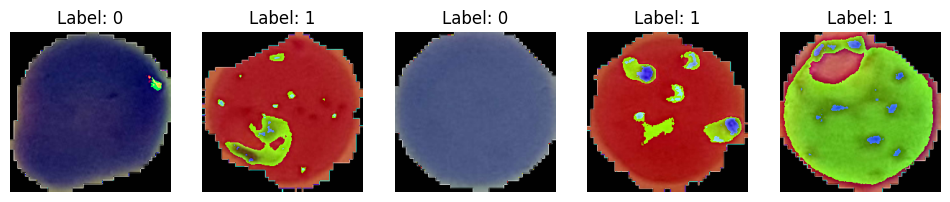

In [6]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # Convert tensor to PIL image
        plt.imshow(transforms.ToPILImage()(images[i]))
        plt.axis("off")

        plt.title(f"Label: {labels[i]}")

    plt.show()


# Get a batch of images and labels from the train dataloader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Show the images with their corresponding labels
show_images(images, labels)

In [7]:
# use transfer learning on pretrained model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# get modle number of input features
num_input_features = model.classifier[1].in_features

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (final fully connected layers)
for param in model.classifier.parameters():
    param.requires_grad = True

# replace classifier with a custom one
model.classifier = torch.nn.Sequential(
    # Add a dense layer with 256 units
    torch.nn.Linear(num_input_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(256, 2)  # 2 classes (Parasitized vs. Uninfected)
)

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set model criteria
criterion = torch.nn.CrossEntropyLoss()

# set model optimizer
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
# create function to train the nn
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):

    # message which epoch we are on
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} / {epochs}")

        # start training phase
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            # move to GPU if available
            images, labels = images.to(device), labels.to(device)

            # zero out gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)

            # compute loss
            loss = criterion(outputs, labels)

            # back prop
            loss.backward()

            # update weights
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()

            total += labels.size(0)

        train_accuracy = 100 * correct / total
        print(
            f"Train Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = 100 * correct / total
        print(
            f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%\n")

In [9]:
train_model(model=model, train_loader=train_dataloader, val_loader=val_dataloader,
            criterion=criterion, optimizer=optimizer, epochs=EPOCHS)

Epoch 1 / 5
Train Loss: 0.3283, Accuracy: 86.14%
Validation Loss: 0.2633, Accuracy: 89.37%

Epoch 2 / 5
Train Loss: 0.2066, Accuracy: 92.56%
Validation Loss: 0.1677, Accuracy: 94.08%

Epoch 3 / 5


KeyboardInterrupt: 